In [1]:
%load_ext autoreload
%autoreload 2

In [173]:
import sys
sys.path.append('../../src/')

from lib.pysoarlib import *
import os
from random import choice, randint

# Visualization
from PIL import Image, ImageDraw, ImageFont
from IPython import display
from time import sleep

# Current working directory (.../tutorials)
cwd = os.path.abspath('')
font_sm = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSansMono.ttf", 14, encoding="unic")

In [194]:
class Food():
    def __init__(self, bonus=False):
        self.points = 10   if bonus else 5
        self.color = 'red' if bonus else 'blue'
        self.bonus = bonus
    def __repr__(self):
        return 'bonusfood' if self.bonus else 'food'
    
    
class Blank():
    def __init__(self):
        pass
    def __repr__(self):
        return 'blank'

    
class Wall():
    def __init__(self):
        pass
    def __repr__(self):
        return 'wall'

    
class World():    
    action_space = ['up', 'left', 'down', 'right']
    
    def __init__(self, display, width=300, height=300, rows=16, cols=16):
        self.n_rows = rows
        self.n_cols = cols
        self.width = width
        self.height = height
        
        # Initialize grid with walls/blank squares
        choices = [Wall(), Blank(), Blank(), Blank(), Blank()]
        self.grid = [[choice(choices) for x in range(cols)] for y in range(rows)] 

        # Fill the rest with food
        for row in range(rows):
            for col in range(cols):
                if isinstance(self.grid[row][col], Blank):
                    self.grid[row][col] = choice([Food(bonus=True), Food(bonus=False)])
            
        self.image = Image.new("RGBA", (self.width, self.height), (255, 255, 255, 0))
        self.canvas = ImageDraw.Draw(self.image)
        self.display = display
        self.cell_w = self.width / cols
        self.cell_h = self.width / rows
     
    def place_eaters(self, eaters):
        # Place the eaters randomly
        for eater in eaters:
            while True:
                row, col = randint(0, self.n_rows - 1), randint(0, self.n_cols - 1)
                if not isinstance(self.grid[row][col], Wall):
                    self.grid[row][col] = eater
                    break

    def step(self, ID: str, action = None):
        """ Returns (observations, reward) """
        ((row_n, col_n), cell) = self.find(ID)
        
        new_row = row_n
        new_col = col_n
        if action == 'up'   : new_row -= 1
        if action == 'down' : new_row += 1
        if action == 'left' : new_col -= 1
        if action == 'right': new_col += 1
        
        if not self.is_valid_move(new_row, new_col):
            # Don't move and return current observations
            return self.observations(row_n, col_n), 0
        
        if self.is_collision((row_n, col_n), (new_row, new_col)):
            raise Exception("no logic to handle collisions")
        else:        
            # aka reward
            points = 0
            if hasattr(self.grid[new_row][new_col], 'points'):
                points = self.grid[new_row][new_col].points
            self.grid[new_row][new_col] = self.grid[row_n][col_n]
            self.grid[row_n][col_n] = Blank()
            return self.observations(new_row, new_col), points


    def is_valid_move(self, row, col):
        # Out of bounds
        if row < 0 or col < 0 or row >= self.n_rows or col >= self.n_cols:
            return False
        is_wall = isinstance(self.grid[row][col], Wall)
        return not is_wall
        
    def is_collision(self, pos1, pos2):
        is_eater_1 = isinstance(self.grid[pos1[0]][pos1[1]], Eater)
        is_eater_2 = isinstance(self.grid[pos2[0]][pos2[1]], Eater)
        return is_eater_1 and is_eater_2
        
    def observations(self, row, col):
        north = '' if row == 0           else self.grid[row - 1][col]
        south = '' if row >= self.n_rows-1 else self.grid[row + 1][col]
        east = ''  if col >= self.n_cols-1 else self.grid[row][col + 1]
        west = ''  if col == 0           else self.grid[row][col - 1]
        return {
            'north' : str(north),
            'south' : str(south),
            'east'  : str(east),
            'west'  : str(west),
            'center': self.grid[row][col],
        }
    
    def find(self, ID: str): 
        for row_n, row in enumerate(self.grid):
            for col_n, cell in enumerate(row):
                if hasattr(cell, 'ID') and cell.ID == ID:
                    return ((row_n, col_n), cell)
        raise Exception(f"Couldn't find {ID}")
        
    def draw(self):
        for y, row in enumerate(self.grid):
            for x, cell in enumerate(row):
                rect = (x * self.cell_w, y * self.cell_h, self.cell_w, self.cell_h)
                if isinstance(cell, Blank):
                    self._draw_rect(rect, fill='white')
                if isinstance(cell, Wall):
                    self._draw_rect(rect, fill='black')
                if isinstance(cell, Eater):
                    self._draw_rect(rect, fill=cell.color)
                    self._center_text(rect, font_sm, str(cell.points))
                if isinstance(cell, Food):
                    padding = .25 * self.cell_w
                    x_pos, y_pos = x * self.cell_w + padding, y * self.cell_h + padding
                    w = self.cell_w - (padding * 2)
                    h = self.cell_h - (padding * 2)
                    self._draw_circle((x_pos, y_pos, w, h), fill=cell.color)
        
        self.display.update(self.image)
        
    
    ####### Private
    def _draw_circle(self, bg, fill: str, outline: str = 'black'):
        x, y, width, height = bg
        self.canvas.ellipse((x, y, x + width, y + height), fill = fill, outline = outline)

    def _draw_rect(self, bg, fill: str):
        x, y, width, height = bg
        self.canvas.rectangle((x, y, x + width, y + height), fill=fill)
        
    def _center_text(self, bg, font, text, color=(255, 0, 0)):
        x, y, width, height = bg
        text_width, text_height = self.canvas.textsize(text, font)
        position = ((width - text_width)/2 + x, (height - text_height)/2 + y)
        self.canvas.text(position, text, color, font=font)

Propose food is looking for

```
(state <s> ^io.input-link.my-location.<dir>.content 
    << normalfood bonusfood >>)
```

In [179]:
class Eater():
    def __init__(self, ID: str, agent_source: str, world: World):
        """ Initialize eater. ID works as the color too. """
        self.ID = ID
        self.color = ID
        self.world = world
        self.agent = SoarAgent(
            agent_name=f"agent {ID}",
            write_to_stdout=True,
            agent_source=agent_source,
            watch_level=1,
        )
        self.points = 0
        self.connector = MoveToFoodConnector(self.agent, self.world)
        self.agent.add_connector("eater", self.connector)
        self.agent.connect()
        
    def set_initial_position(self):
        pos, cell = self.world.find(self.ID)
        self.position = pos
        self.update_wm_from_observations()

    # Get the objects on all four sides of the agent
    def update_wm_from_observations(self):
        observations = self.world.observations(self.position[0], self.position[1])
        
        self.connector.north.set_value = observations['north']
        self.connector.south.set_value = observations['south']
        self.connector.east.set_value = observations['south']
        self.connector.west.set_value = observations['west']
        
        
class MoveToFoodConnector(AgentConnector):
    def __init__(self, agent, world):
        AgentConnector.__init__(self, agent)
        self.move_command = "move-to-food"
        self.world = world
        # TODO Explain
        self.add_output_command(self.move_command)
        # content is "bonusfood" | "normalfood" | "wall" "blank"
        self.north = SoarWME("io.input-link.my-location.north.content", "")
        self.south = SoarWME("io.input-link.my-location.south.content", "")
        self.east = SoarWME("io.input-link.my-location.east.content", "")
        self.west = SoarWME("io.input-link.my-location.west.content", "")

    def on_input_phase(self, input_link):
        print("on input phase")
        for direction in [self.north, self.south, self.east, self.west]:
            if not direction.is_added():
                direction.add_to_wm(input_link)
            # TODO Unsure what this does
            else:
                direction.update_wm()

    def on_init_soar(self):
        for direction in [self.north, self.south, self.east, self.west]:
            # TODO Unsure why we'd do this
            direction.remove_from_wm()

    def on_output_event(self, command_name, root_id):
        print("command", command_name)
        if command_name == self.move_command:
            self.process_move_command(root_id)
    
    def process_move_command(self, root_id):
        direction = root_id.GetChildString("io.input-link.my-location")
        print("Process move command", direction)
#         if number:
#             self.num.set_value(self.num.val + number)
        # TODO What does this do?
        root_id.AddStatusComplete()

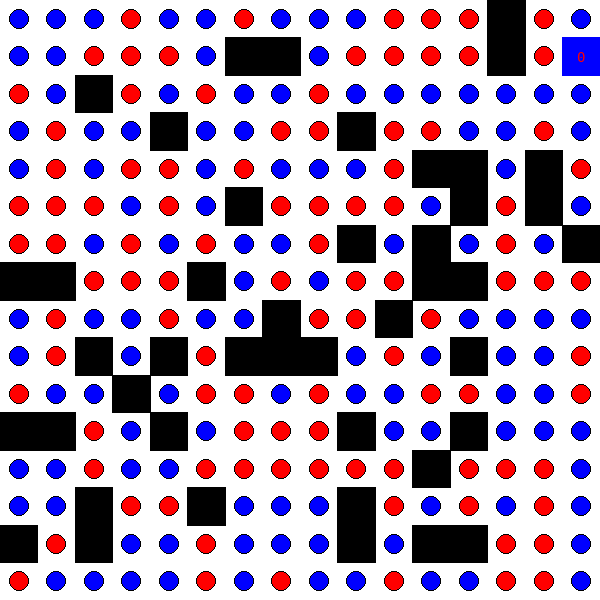

--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.


KeyboardInterrupt: 

In [195]:
d = display.display("z", display_id=True)

world = World(d, width=600, height=600, rows=16, cols=16)

source = cwd +  "/3_move_to_food.soar"
eaters = [
    Eater('blue', source, world),
#     Eater('red', 'red'),
#     Eater('green','green'),
]

world.place_eaters(eaters)

[e.set_initial_position() for e in eaters]

world.draw()
for i in range(200):
    
    for eater in eaters:
        action = 'right'
        (position, reward) = world.step(eater.ID, action)
        eater.points += reward
    
    world.draw()
    sleep(1)

In [107]:

#move_simple_agentUse the "Add working memory" command to manually inject a working element into the agent
# This is often used to give Soar knowledge of the outside world
# move_simple_agent.execute_command("add-wme S1 ^io input-link +", print_res=True);
# move_simple_agent.execute_command("add-wme S1 ^io.input-link dir +", print_res=True);
# move_simple_agent.execute_command("step", print_res=True)
# move_simple_agent.execute_command("step", print_res=True);

--------- SOURCING PRODUCTIONS ------------
Total: 3 productions sourced.
on input phase
1:    ==>S: S2 (state no-change)
step
--> 1 decision cycle executed. No rules fired.
on input phase
Update
Update
Update
Update
2:       ==>S: S3 (state no-change)
step
--> 2 decision cycles executed. No rules fired.


#### Eaters world

Like PACMAN where *eaters* 


we've got this move to food program but its dumb, only senses whats around it
this is a problem, the eater will stop when theres nothing immediately around it

p53 pic of not knowing what to do 


